In [71]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [72]:
df = pd.read_csv("dirty_v3_path.csv").head(5000)

In [73]:
df.head()

,Age,Gender,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,random_notes,noise_col
0,46.0,Male,Diabetes,137.04,135.27,28.90,96.04,6,231.88,210.56,7.61,0,0,-0.20,3.54,0,5.07,6.05,lorem,-137.057211
1,22.0,Male,Healthy,71.58,113.27,26.29,97.54,2,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72,ipsum,-11.230610
2,50.0,NaN,Asthma,95.24,NaN,22.53,90.31,2,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82,ipsum,98.331195
3,57.0,NaN,Obesity,NaN,130.53,38.47,96.60,5,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33,lorem,44.187175
4,66.0,Female,Hypertension,95.15,178.17,31.12,94.90,4,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64,lorem,44.831426


In [74]:
df = df.drop(columns=['random_notes', 'noise_col'])

In [75]:
df.shape

(5000, 18)

In [76]:
df.isna().sum()

Age                  727
Gender               745
Medical Condition    743
Glucose              750
Blood Pressure       722
BMI                    0
Oxygen Saturation      0
LengthOfStay           0
Cholesterol            0
Triglycerides          0
HbA1c                  0
Smoking                0
Alcohol                0
Physical Activity      0
Diet Score             0
Family History         0
Stress Level           0
Sleep Hours            0
dtype: int64

Chci predikovat medicinal condition, takže null hodnoty dropnu

In [77]:
df = df[~df['Medical Condition'].isna()]

In [78]:
df.shape

(4257, 18)

In [79]:
df.isna().sum()

Age                  621
Gender               636
Medical Condition      0
Glucose              627
Blood Pressure       622
BMI                    0
Oxygen Saturation      0
LengthOfStay           0
Cholesterol            0
Triglycerides          0
HbA1c                  0
Smoking                0
Alcohol                0
Physical Activity      0
Diet Score             0
Family History         0
Stress Level           0
Sleep Hours            0
dtype: int64

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4257 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                3636 non-null   float64
 1   Gender             3621 non-null   object 
 2   Medical Condition  4257 non-null   object 
 3   Glucose            3630 non-null   float64
 4   Blood Pressure     3635 non-null   float64
 5   BMI                4257 non-null   float64
 6   Oxygen Saturation  4257 non-null   float64
 7   LengthOfStay       4257 non-null   int64  
 8   Cholesterol        4257 non-null   float64
 9   Triglycerides      4257 non-null   float64
 10  HbA1c              4257 non-null   float64
 11  Smoking            4257 non-null   int64  
 12  Alcohol            4257 non-null   int64  
 13  Physical Activity  4257 non-null   float64
 14  Diet Score         4257 non-null   float64
 15  Family History     4257 non-null   int64  
 16  Stress Level       4257 non-n

In [81]:
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Glucose'] = df['Glucose'].fillna(df['Glucose'].mean())
df['Blood Pressure'] = df['Blood Pressure'].fillna(df['Blood Pressure'].mean())
df['Gender'] = df['Gender'].fillna('Unknown')

<Figure size 1200x600 with 0 Axes>

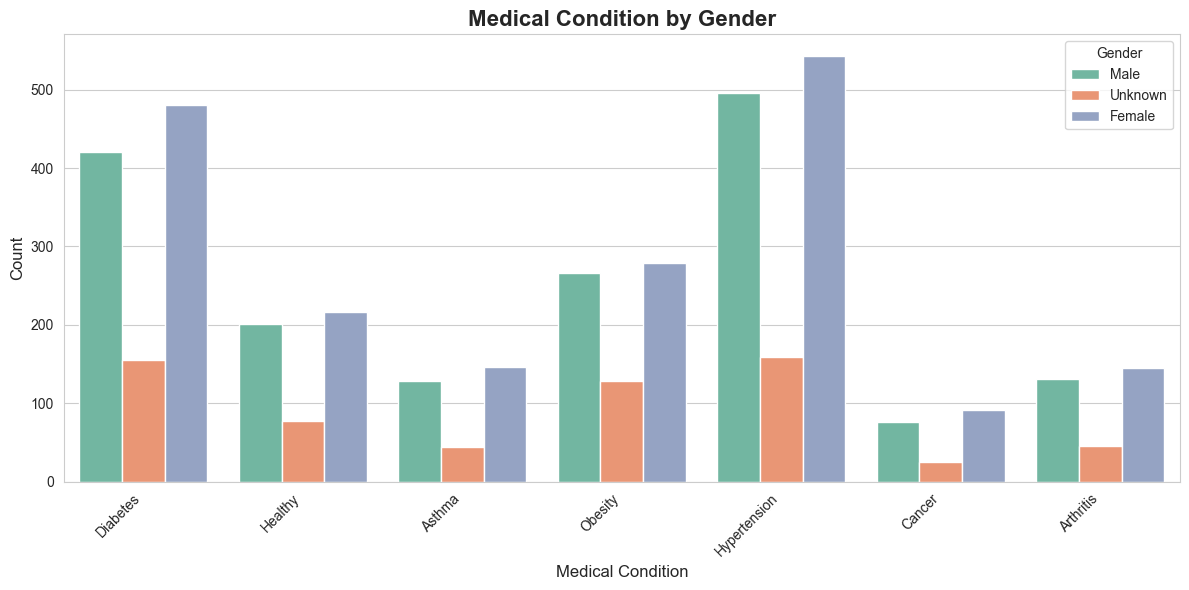

In [82]:
# Nastavení stylu
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Vytvoření crosstab pro počty
condition_gender = pd.crosstab(df['Medical Condition'], df['Gender'])

# Alternativně s seaborn pro hezčí vzhled:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Medical Condition', hue='Gender', palette='Set2')
plt.title('Medical Condition by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Medical Condition', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [83]:
df['Gender'].value_counts()

Gender
Female     1902
Male       1719
Unknown     636
Name: count, dtype: int64

Z grafu se nedá vyhodnotit, že by jedno pohlaví bylo více nemocné než druhé. Vyšší hodnoty u žen jsou způsobeny tím, že ženy jsou ve vzorku více zastoupeny.

Float sloupce: ['Age', 'Glucose', 'Blood Pressure', 'BMI', 'Oxygen Saturation', 'Cholesterol', 'Triglycerides', 'HbA1c', 'Physical Activity', 'Diet Score', 'Stress Level', 'Sleep Hours']


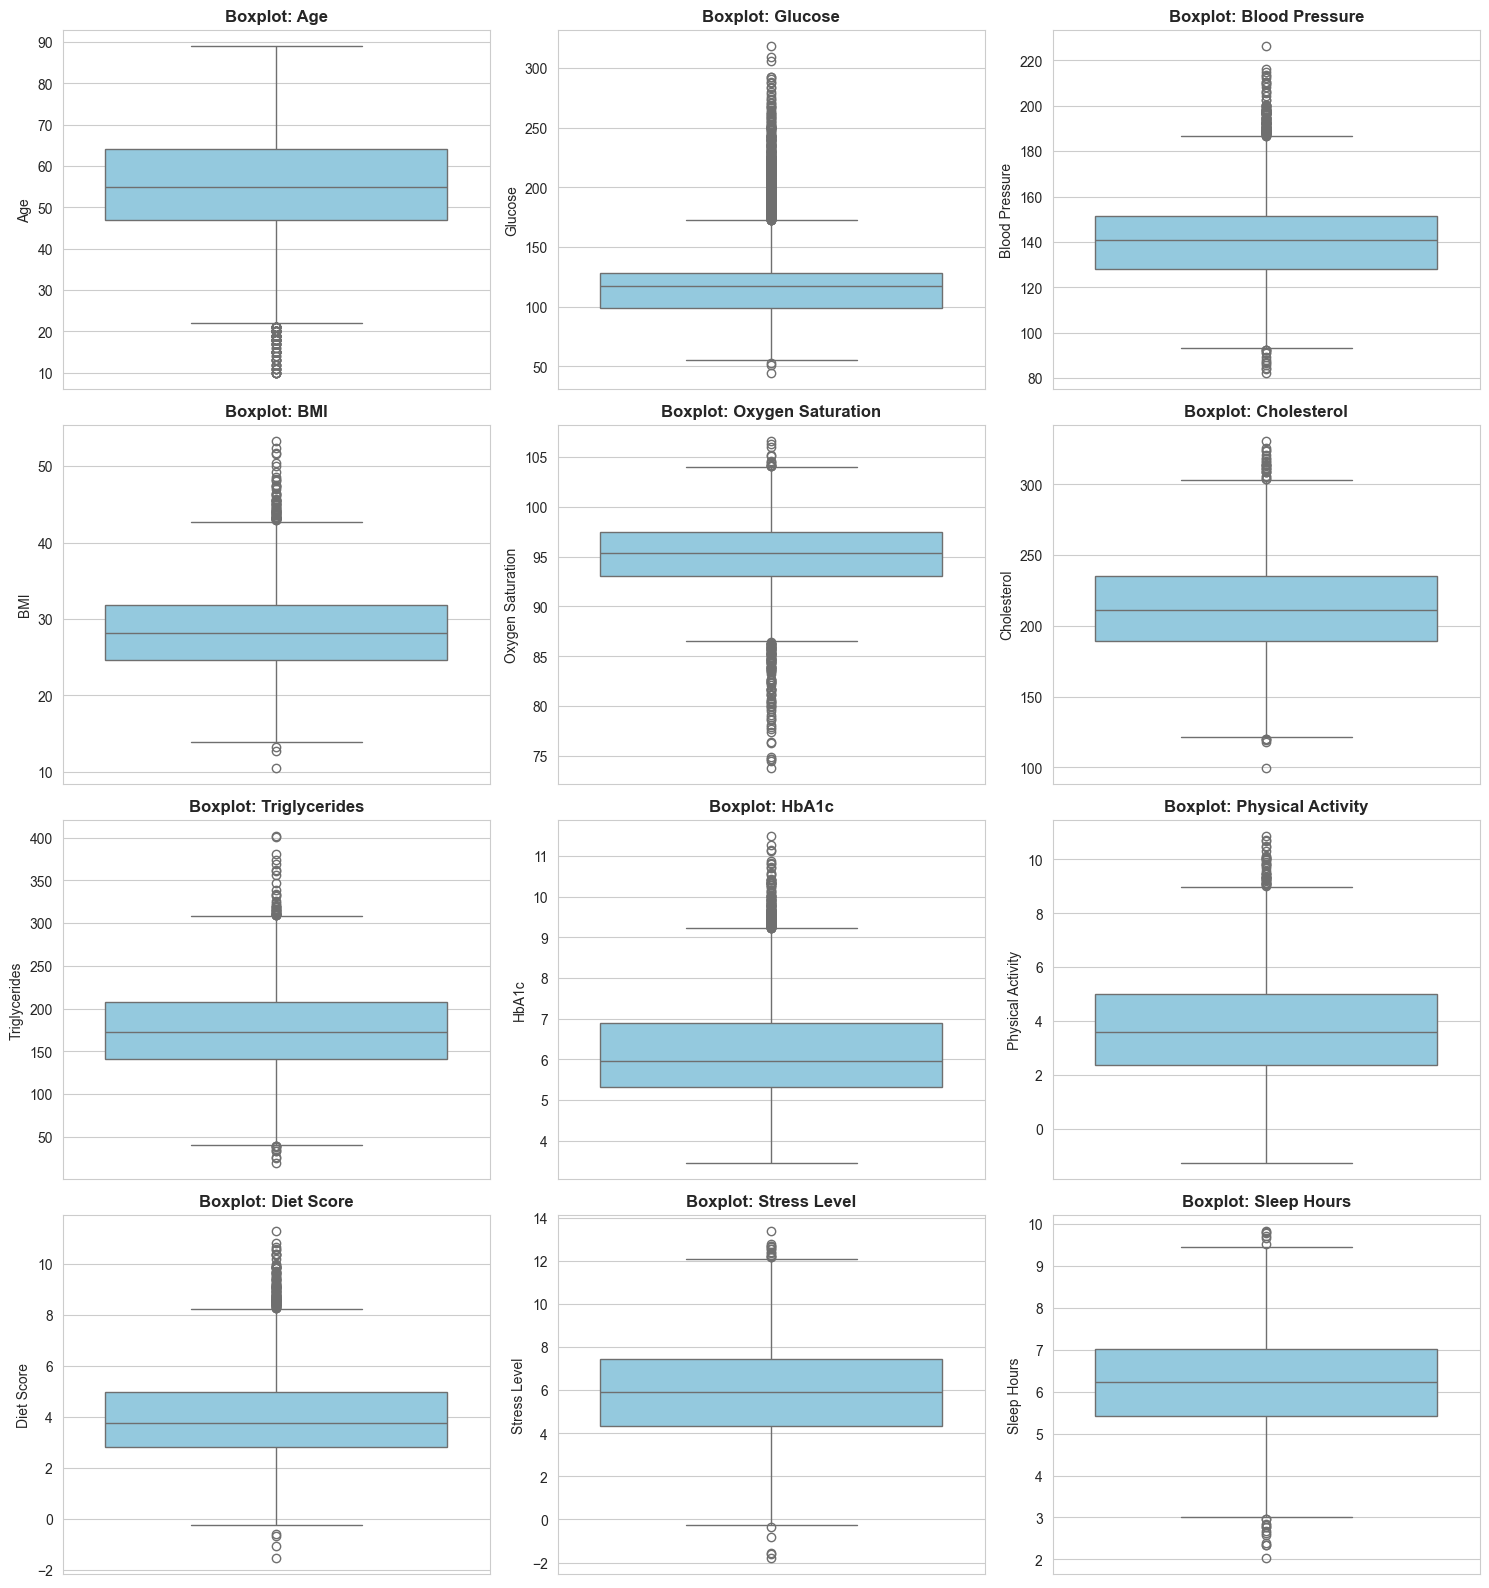

In [84]:
# Vyber všechny float sloupce
float_columns = df.select_dtypes(include=['float64']).columns.tolist()

print(f"Float sloupce: {float_columns}")

# Vytvoření boxplotů pro všechny float sloupce
n_cols = 3  # Počet sloupců v gridu
n_rows = (len(float_columns) + n_cols - 1) // n_cols  # Počet řádků

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Zploštění pro jednodušší iteraci

for i, col in enumerate(float_columns):
    sns.boxplot(data=df, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot: {col}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(col, fontsize=10)

# Skrytí prázdných subplotů
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Průměrný jedinec datasetu naspí něco málo nad 6 hodin, není příliš fyzicky aktivní, jeho strava je podprůměrná, má nad 50 let a žije poměrně stresuplným životem.

V důsledku toho je zvýšený cholesterol a krevní tlak.

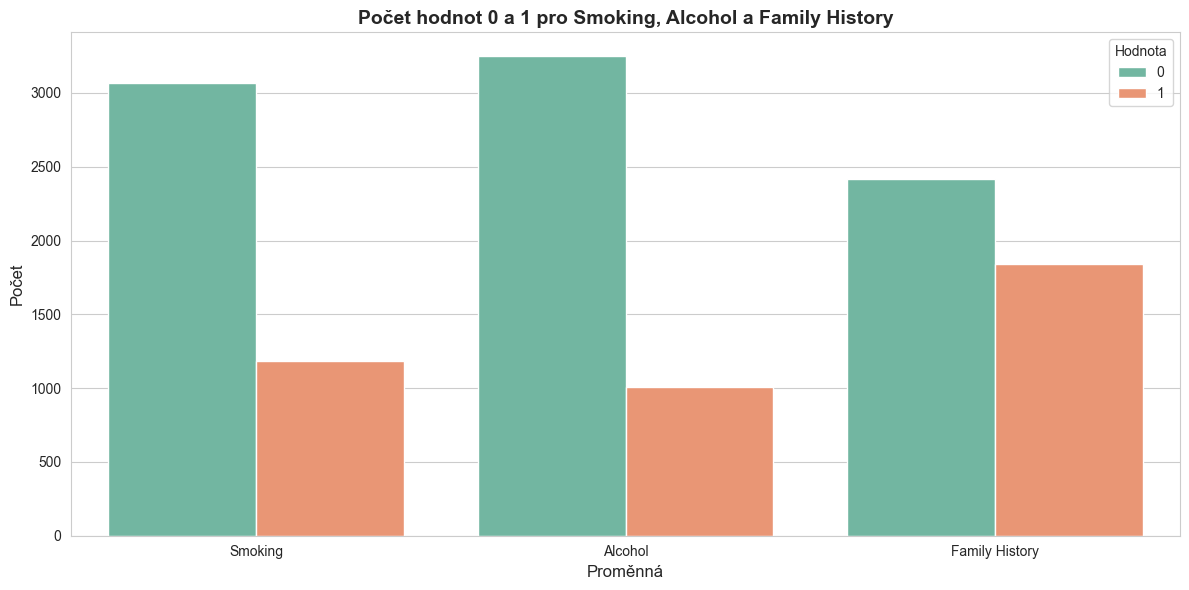

In [85]:
# Všechny tři proměnné vedle sebe
columns_to_plot = ['Smoking', 'Alcohol', 'Family History']

# Vytvoř data pro grouped barplot
data_for_plot = []
for col in columns_to_plot:
    counts = df[col].value_counts().sort_index()
    for val, count in counts.items():
        data_for_plot.append({'Variable': col, 'Value': str(int(val)), 'Count': count})

plot_df = pd.DataFrame(data_for_plot)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='Variable', y='Count', hue='Value', palette='Set2')
plt.title('Počet hodnot 0 a 1 pro Smoking, Alcohol a Family History', fontsize=14, fontweight='bold')
plt.xlabel('Proměnná', fontsize=12)
plt.ylabel('Počet', fontsize=12)
plt.legend(title='Hodnota')
plt.tight_layout()
plt.show()

Většina jedinců nekouří a ani nepije, ale je odhaleno, že spousta jedinců již má nemoc v rodině.

Taktéž více než polovina jedinců, má nemoc již v rodině. Ale vzhledem k nejčastějším nemocím bych si tipnul, že to hodně bude způsobeno tím, že převzali od rodičů špatnou životosprávu.

C:\Users\ajrac\AppData\Local\Temp\ipykernel_3180\432123048.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


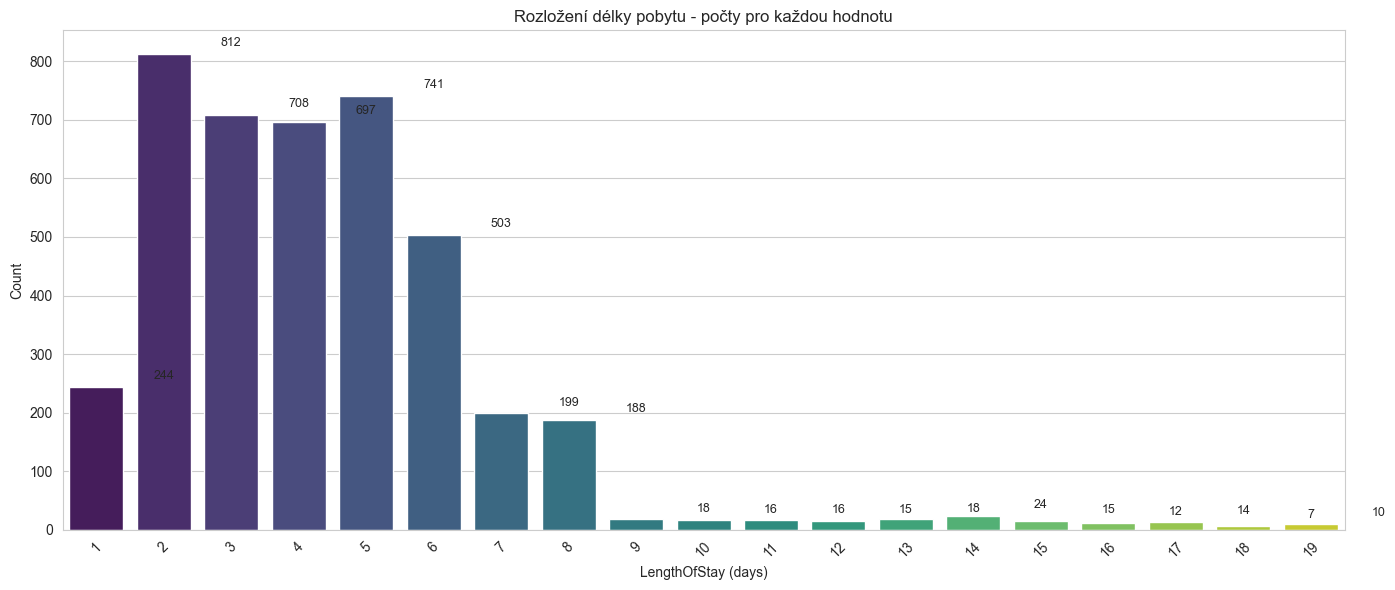

In [86]:
col = 'LengthOfStay'
s = pd.to_numeric(df[col], errors='coerce').astype(int)  # předpoklad: žádné NaN, sloupec existuje
counts = s.value_counts().sort_index()

plt.figure(figsize=(14,6))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.xlabel('LengthOfStay (days)')
plt.ylabel('Count')
plt.title('Rozložení délky pobytu - počty pro každou hodnotu')
plt.xticks(rotation=45)
for x, y in zip(counts.index, counts.values):
    plt.text(x, y + max(counts.values) * 0.01, int(y), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

Většina jedinců byla v nemocnici jen mezi 1 až 8 dny.

In [87]:
float_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
for c in float_cols:
    df = df[df[c] >= 0]

Mínusové hodnoty nedávají smysl a není jich hodně, tak je dropnu.

In [88]:
df.shape

(4197, 18)

C:\Users\ajrac\AppData\Local\Temp\ipykernel_3180\2007734404.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=condition_counts.index, x=condition_counts.values, palette='Set2', orient='h')


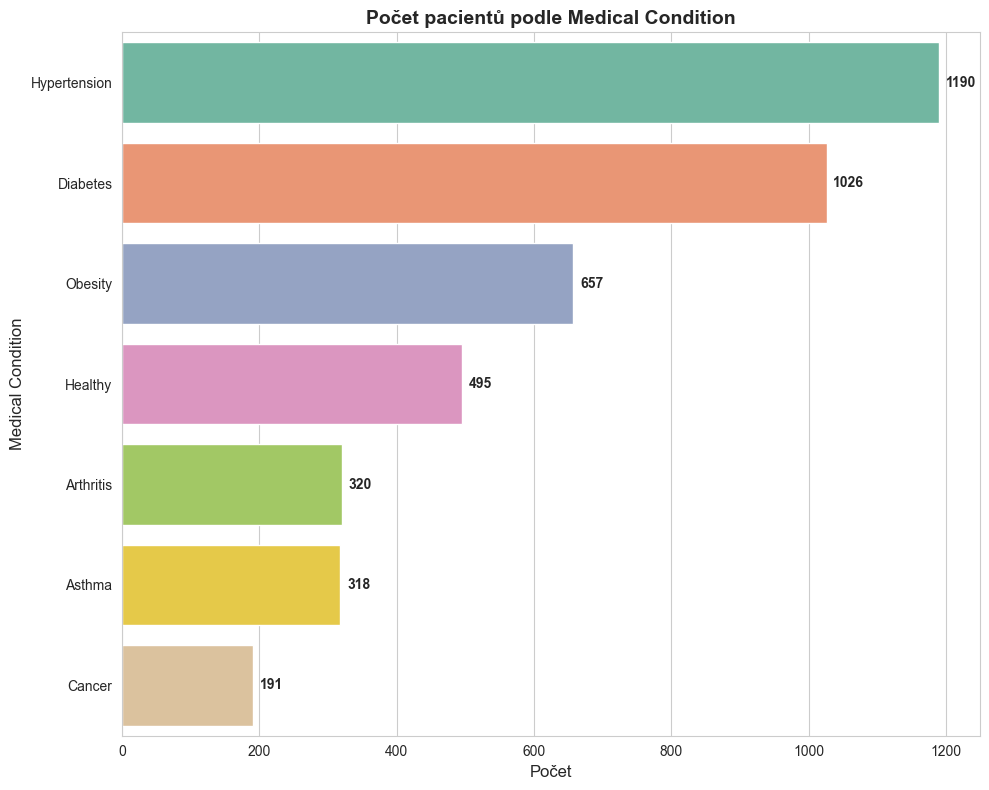

In [89]:
plt.figure(figsize=(10, 8))
condition_counts = df['Medical Condition'].value_counts()

sns.barplot(y=condition_counts.index, x=condition_counts.values, palette='Set2', orient='h')
plt.title('Počet pacientů podle Medical Condition', fontsize=14, fontweight='bold')
plt.xlabel('Počet', fontsize=12)
plt.ylabel('Medical Condition', fontsize=12)

# Přidej hodnoty na konec sloupců
for i, v in enumerate(condition_counts.values):
    plt.text(v + 10, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Nejvíce rozšířenou chorobou v datasetu je Hypertenze a cukrovka, což se vzhledem k hodnotám krevního tlaku a cholesterolu dá čekat. Co mě nicméně překvapuje je to, že obezita se objevuje jen zhruba u pětiny datasetu, vzlášť když cukrovka je u čtvrtiny. Předpokládal jsem, že počet cukrovky a obezity bude velmi podobný, nicméně tomu tak není.

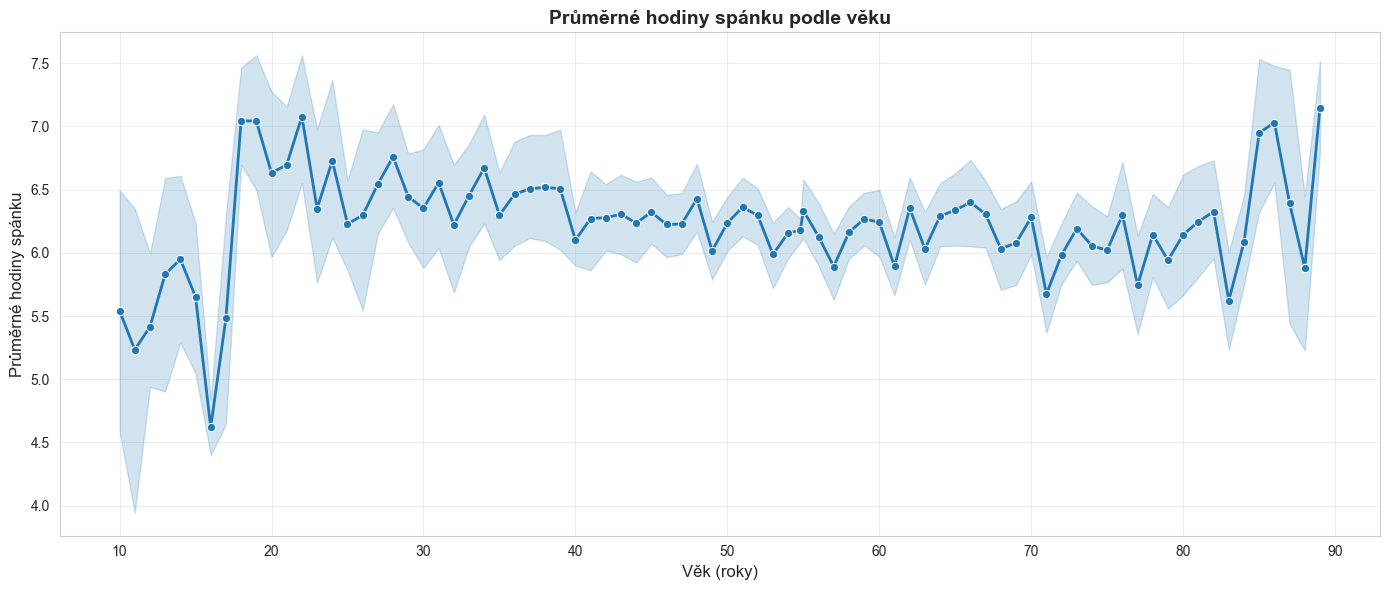

In [90]:
age_sleep = df.groupby('Age')['Sleep Hours'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Age', y='Sleep Hours', marker='o', linewidth=2, markersize=6)
plt.title('Průměrné hodiny spánku podle věku', fontsize=14, fontweight='bold')
plt.xlabel('Věk (roky)', fontsize=12)
plt.ylabel('Průměrné hodiny spánku', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Větší korelace mezi věkem a počtu odpsaných hodin není, nicméně skupina od 10 do 18 let má velmi málo odpsaných hodin, což může přispívat k nemoci.

C:\Users\ajrac\AppData\Local\Temp\ipykernel_3180\2844354680.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


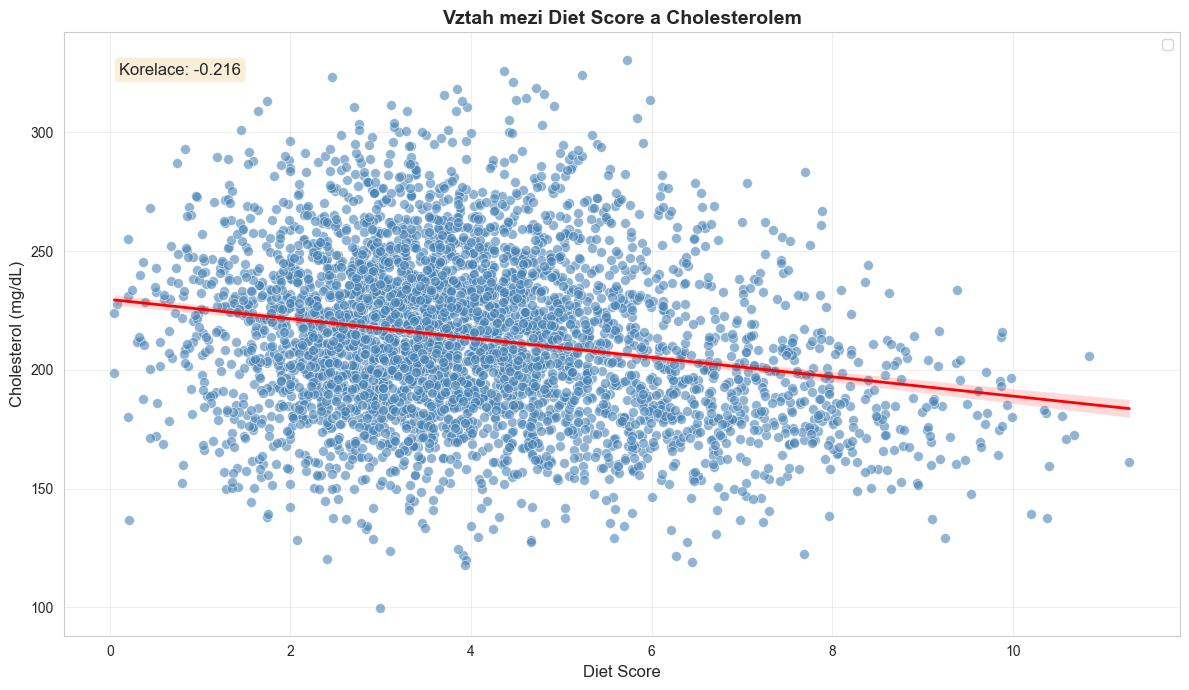

In [91]:
# Scatter plot - Diet Score vs Cholesterol
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='Diet Score', y='Cholesterol', alpha=0.6, s=50, color='steelblue')

# Přidej regresní čáru
sns.regplot(data=df, x='Diet Score', y='Cholesterol', scatter=False, color='red', 
            line_kws={'linewidth': 2, 'label': 'Regresní čára'})

plt.title('Vztah mezi Diet Score a Cholesterolem', fontsize=14, fontweight='bold')
plt.xlabel('Diet Score', fontsize=12)
plt.ylabel('Cholesterol (mg/dL)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Vypočítej a zobraz korelaci
correlation = df['Diet Score'].corr(df['Cholesterol'])
plt.text(0.05, 0.95, f'Korelace: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

C:\Users\ajrac\AppData\Local\Temp\ipykernel_3180\455044292.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


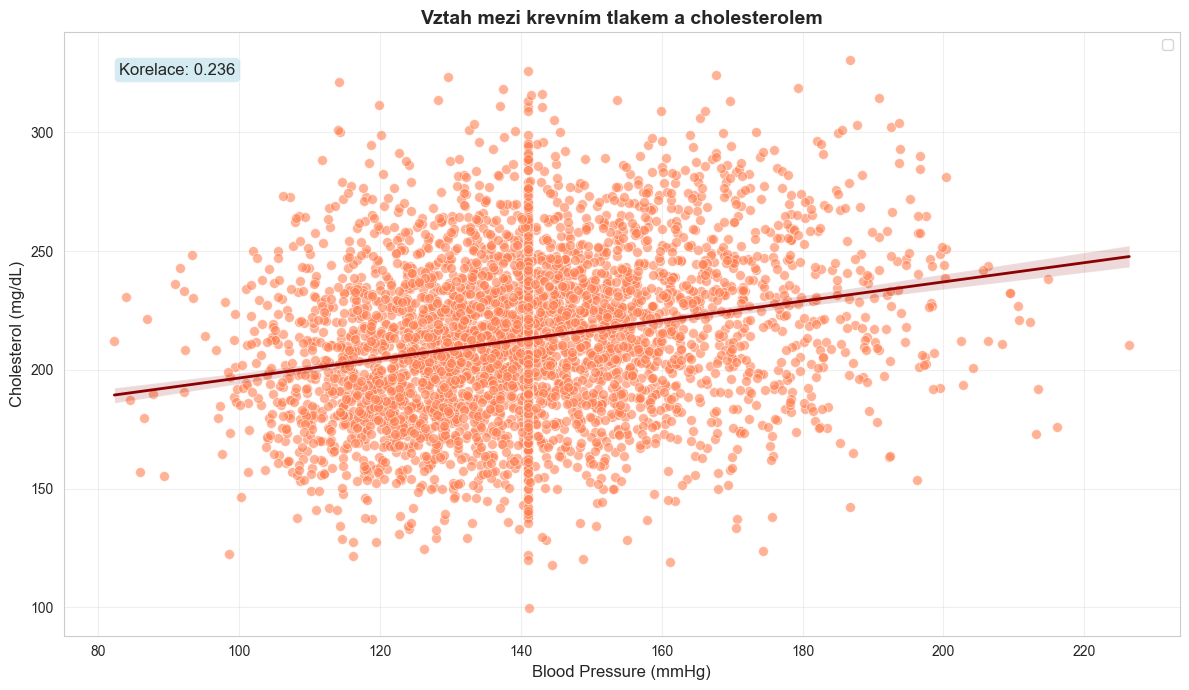

In [92]:
# Scatter plot - Blood Pressure vs Cholesterol
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='Blood Pressure', y='Cholesterol', alpha=0.6, s=50, color='coral')

# Přidej regresní čáru
sns.regplot(data=df, x='Blood Pressure', y='Cholesterol', scatter=False, color='darkred', 
            line_kws={'linewidth': 2, 'label': 'Regresní čára'})

plt.title('Vztah mezi krevním tlakem a cholesterolem', fontsize=14, fontweight='bold')
plt.xlabel('Blood Pressure (mmHg)', fontsize=12)
plt.ylabel('Cholesterol (mg/dL)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Vypočítej a zobraz korelaci
correlation = df['Blood Pressure'].corr(df['Cholesterol'])
plt.text(0.05, 0.95, f'Korelace: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

Zde jde vidět, že čím má člověk menší diet score, tím výšší má cholesterol.

A s tím souvisí i krevní tlak, čím vyšší je cholesterol, tím vyšší je krevní tlak.

Gender encoduji pomocí dummy encodingu, protože gender se nedá řadit a je ho v datasetu více než 2.

In [93]:
df = pd.get_dummies(df, columns=['Gender'], drop_first=False)

Převedu bool na int pro clustering.

In [94]:
for c in df.select_dtypes(include=['bool']).columns:
    df[c] = df[c].astype(int)
df.head()


,Age,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,Gender_Female,Gender_Male,Gender_Unknown
1,22.0,Healthy,71.580000,113.27000,26.29,97.54,2,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72,0,1,0
2,50.0,Asthma,95.240000,140.99123,22.53,90.31,2,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82,0,0,1
3,57.0,Obesity,123.713377,130.53000,38.47,96.60,5,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33,0,0,1
4,66.0,Hypertension,95.150000,178.17000,31.12,94.90,4,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64,1,0,0
5,50.0,Hypertension,107.000000,171.80000,25.33,95.21,5,233.10,203.67,5.48,1,0,5.01,4.65,0,7.25,6.35,0,1,0


Medical condition se nedá seřadit, takže se nehodí ordinal encoding, ale je to sloupec pro klasifikaci, takže se nehodí ani dummy encoding, tím páde to encoduji pomocí label encodingu.

In [95]:
clean_med = df['Medical Condition'].astype(str).str.strip()
le = LabelEncoder()
df['med_label'] = le.fit_transform(clean_med)
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

In [96]:
label_map

{'Arthritis': np.int64(0),
 'Asthma': np.int64(1),
 'Cancer': np.int64(2),
 'Diabetes': np.int64(3),
 'Healthy': np.int64(4),
 'Hypertension': np.int64(5),
 'Obesity': np.int64(6)}

In [97]:
df['Oxygen Saturation'] = df['Oxygen Saturation'].clip(upper=100.0)

Clipnu saturaci kyslíku na 100, pravděpodobně se jedná o pár chyb měření.

Biologická data nejsu lineární, takže MinMaxScaler by s nimi měl problém, takže je třeba je rozdělit.

Pro lineární data je v pořádku použít MinMaxScaler, nicméně pro biologická data bude třeba použít PowerTransformer, který narovná data do Gaussovy křivky.

Speciálním případem je pak Oxygen Saturation, kde jsou data silně šikmé z leva, ale i zde je možné využít MinMaxSaler, jen nesmí být chybná data, např. 0 nebo 200%.

Zrcadlovým případem je pak LengthOfStay, nicméně data jsou šikmá z leva. Šikmost z leva je více nebezpečná než z prava. Problém pravého ocasu je ten, že směrem doprava často neexistuje strop, zatímco pro levý ocas existuje.

In [98]:
biological_features = [
    'Glucose', 'Blood Pressure', 'BMI', 'Cholesterol', 
    'Triglycerides', 'HbA1c', 'LengthOfStay'
]

linear_features = [
    'Age', 'Physical Activity', 'Diet Score', 'Stress Level', 
    'Sleep Hours', 'Oxygen Saturation'
]

In [99]:
bio_pipeline = Pipeline([
    ('log_normal', PowerTransformer(method='box-cox')),
    ('scale', MinMaxScaler())
])

linear_pipeline = Pipeline([
    ('minmax', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('bio_transform', bio_pipeline, biological_features),
        ('linear_transform', linear_pipeline, linear_features)
    ],
    verbose_feature_names_out=False # Zachová hezké názvy sloupců (v novějších scikit-learn)
).set_output(transform="pandas")

In [100]:
df_transformed = preprocessor.fit_transform(df)
df[df_transformed.columns] = df_transformed

In [101]:
df.head()

,Age,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,...,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,Gender_Female,Gender_Male,Gender_Unknown,med_label
1,0.151899,Healthy,0.396486,0.327152,0.506573,0.906035,0.202245,0.353968,0.425599,0.464555,...,0,0.746999,0.520463,0,0.438202,0.729487,0,1,0,4
2,0.506329,Asthma,0.573438,0.545165,0.411527,0.629870,0.202245,0.572701,0.521085,0.590131,...,0,0.459834,0.409253,1,0.229963,0.357692,0,0,1,1
3,0.594937,Obesity,0.703562,0.468959,0.760008,0.870130,0.499109,0.499619,0.562488,0.752321,...,0,0.289012,0.295374,0,0.223970,0.423077,0,0,1,6
4,0.708861,Hypertension,0.572917,0.772783,0.615416,0.805195,0.423529,0.748921,0.386577,0.645272,...,1,0.325946,0.298043,0,0.476404,0.591026,1,0,0,5
5,0.506329,Hypertension,0.634736,0.737739,0.483275,0.817036,0.499109,0.646543,0.613242,0.570886,...,0,0.459834,0.409253,0,0.541573,0.553846,0,1,0,5


A jelikož Medical condition je pro klasifikaci, tak s ním nebudu pracovat během clusteringu.

In [102]:
X_clust = df.drop(columns=['Medical Condition', 'med_label'])

In [103]:
X_clust.head()

,Age,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,Gender_Female,Gender_Male,Gender_Unknown
1,0.151899,0.396486,0.327152,0.506573,0.906035,0.202245,0.353968,0.425599,0.464555,0,0,0.746999,0.520463,0,0.438202,0.729487,0,1,0
2,0.506329,0.573438,0.545165,0.411527,0.629870,0.202245,0.572701,0.521085,0.590131,0,0,0.459834,0.409253,1,0.229963,0.357692,0,0,1
3,0.594937,0.703562,0.468959,0.760008,0.870130,0.499109,0.499619,0.562488,0.752321,0,0,0.289012,0.295374,0,0.223970,0.423077,0,0,1
4,0.708861,0.572917,0.772783,0.615416,0.805195,0.423529,0.748921,0.386577,0.645272,0,1,0.325946,0.298043,0,0.476404,0.591026,1,0,0
5,0.506329,0.634736,0.737739,0.483275,0.817036,0.499109,0.646543,0.613242,0.570886,1,0,0.459834,0.409253,0,0.541573,0.553846,0,1,0


Tímto jsou všechna data již připravena a můžou se použít pro clustering.

In [104]:
results_df = X_clust.copy()

1. experiment - KMeans
V tomto prvním experimentu využiji data předzpracovaná pomocí `PowerTransformer` (pro biologické rysy) a `MinMaxScaler` (pro lineární rysy). Jako shlukovací metodu použiji standardní **KMeans**.

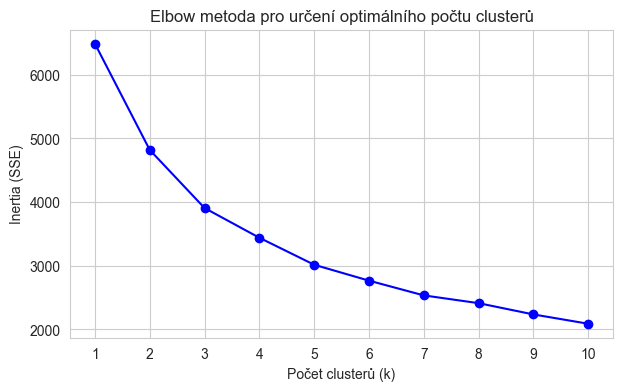

In [105]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clust)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K, inertia, "o-", color="blue")
plt.xlabel("Počet clusterů (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow metoda pro určení optimálního počtu clusterů")
plt.xticks(K)
plt.grid(True)
plt.show()

Z elbow metody není jasné, jaký počet clusterů by byl nejlepší, takže je třeba využít silhouette score

In [106]:
for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_clust)
    score = silhouette_score(X_clust, labels)
    print(f"k = {k}: Silhouette Score = {score:.4f}")

k = 2: Silhouette Score = 0.2557
k = 3: Silhouette Score = 0.3258
k = 3: Silhouette Score = 0.3258
k = 4: Silhouette Score = 0.2746
k = 4: Silhouette Score = 0.2746
k = 5: Silhouette Score = 0.2703
k = 5: Silhouette Score = 0.2703


Nejlepší počet clusterů je 3.

In [107]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [108]:
labels_exp1 = kmeans.fit_predict(X_clust)
results_df['Cluster_Exp1_KMeans'] = labels_exp1

2. experiment - Agglomerative Clustering
V tomto experimentu využiji stejná předzpracovaná data (`X_clust`), ale použiji jinou shlukovací metodu - **Agglomerative Clustering** (hierarchické shlukování). Tato metoda buduje hierarchii shluků a nevyžaduje náhodnou inicializaci jako KMeans.

In [109]:
for k in [2, 3, 4, 5]:
    agglo = AgglomerativeClustering(n_clusters=k)
    labels = agglo.fit_predict(X_clust)
    score = silhouette_score(X_clust, labels)
    print(f"k = {k}: Silhouette Score = {score:.4f}")

k = 2: Silhouette Score = 0.2557
k = 3: Silhouette Score = 0.3258
k = 3: Silhouette Score = 0.3258
k = 4: Silhouette Score = 0.2723
k = 4: Silhouette Score = 0.2723
k = 5: Silhouette Score = 0.2544
k = 5: Silhouette Score = 0.2544


In [110]:
agglo = AgglomerativeClustering(n_clusters=3)
labels_exp2 = agglo.fit_predict(X_clust)
results_df['Cluster_Exp2_Agglo'] = labels_exp2

3. experiment - PCA + KMeans
V tomto experimentu změním **preprocessing**. Použiji **PCA (Principal Component Analysis)** pro redukci dimenze dat. To může pomoci odstranit šum a korelované proměnné. Následně na tato transformovaná data aplikuji **KMeans**.

In [111]:
pca = PCA(n_components=0.95) # Zachovat 95% variance
X_pca = pca.fit_transform(X_clust)

print(f"Původní počet rysů: {X_clust.shape[1]}")
print(f"Počet rysů po PCA: {X_pca.shape[1]}")

Původní počet rysů: 19
Počet rysů po PCA: 12


In [112]:
print("Hledání optimálního počtu clusterů pro PCA + KMeans:")
for k in [2, 3, 4, 5]:
    kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_pca.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print(f"k = {k}: Silhouette Score = {score:.4f}")

Hledání optimálního počtu clusterů pro PCA + KMeans:
k = 2: Silhouette Score = 0.2721
k = 2: Silhouette Score = 0.2721
k = 3: Silhouette Score = 0.3467
k = 3: Silhouette Score = 0.3467
k = 4: Silhouette Score = 0.2990
k = 4: Silhouette Score = 0.2990
k = 5: Silhouette Score = 0.2984
k = 5: Silhouette Score = 0.2984


In [113]:
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_exp3 = kmeans_pca.fit_predict(X_pca)
results_df['Cluster_Exp3_PCA_KMeans'] = labels_exp3

In [114]:
print("Počty v clusterech - Experiment 1 (KMeans):")
print(results_df['Cluster_Exp1_KMeans'].value_counts())
print("\nPočty v clusterech - Experiment 2 (Agglomerative):")
print(results_df['Cluster_Exp2_Agglo'].value_counts())
print("\nPočty v clusterech - Experiment 3 (PCA + KMeans):")
print(results_df['Cluster_Exp3_PCA_KMeans'].value_counts())

Počty v clusterech - Experiment 1 (KMeans):
Cluster_Exp1_KMeans
1    1699
2    1409
0    1089
Name: count, dtype: int64

Počty v clusterech - Experiment 2 (Agglomerative):
Cluster_Exp2_Agglo
0    1875
1    1699
2     623
Name: count, dtype: int64

Počty v clusterech - Experiment 3 (PCA + KMeans):
Cluster_Exp3_PCA_KMeans
0    1875
1    1699
2     623
Name: count, dtype: int64


# Porovnání výsledků experimentů

Pro porovnání jednotlivých metod využiji několik vizualizací:
1. **Vizualizace v 2D prostoru (pomocí PCA):** Zobrazíme, jak jednotlivé metody rozdělily data, promítnutá do dvou hlavních komponent. To nám umožní vizuálně posoudit separaci shluků.
2. **Porovnání velikosti clusterů:** Graf ukazující, jak vyvážené (nebo nevyvážené) clustery jednotlivé metody vytvořily.
3. **Porovnání Silhouette Score:** Kvantitativní zhodnocení kvality shlukování (počítáno na původních datech `X_clust` pro férové srovnání).

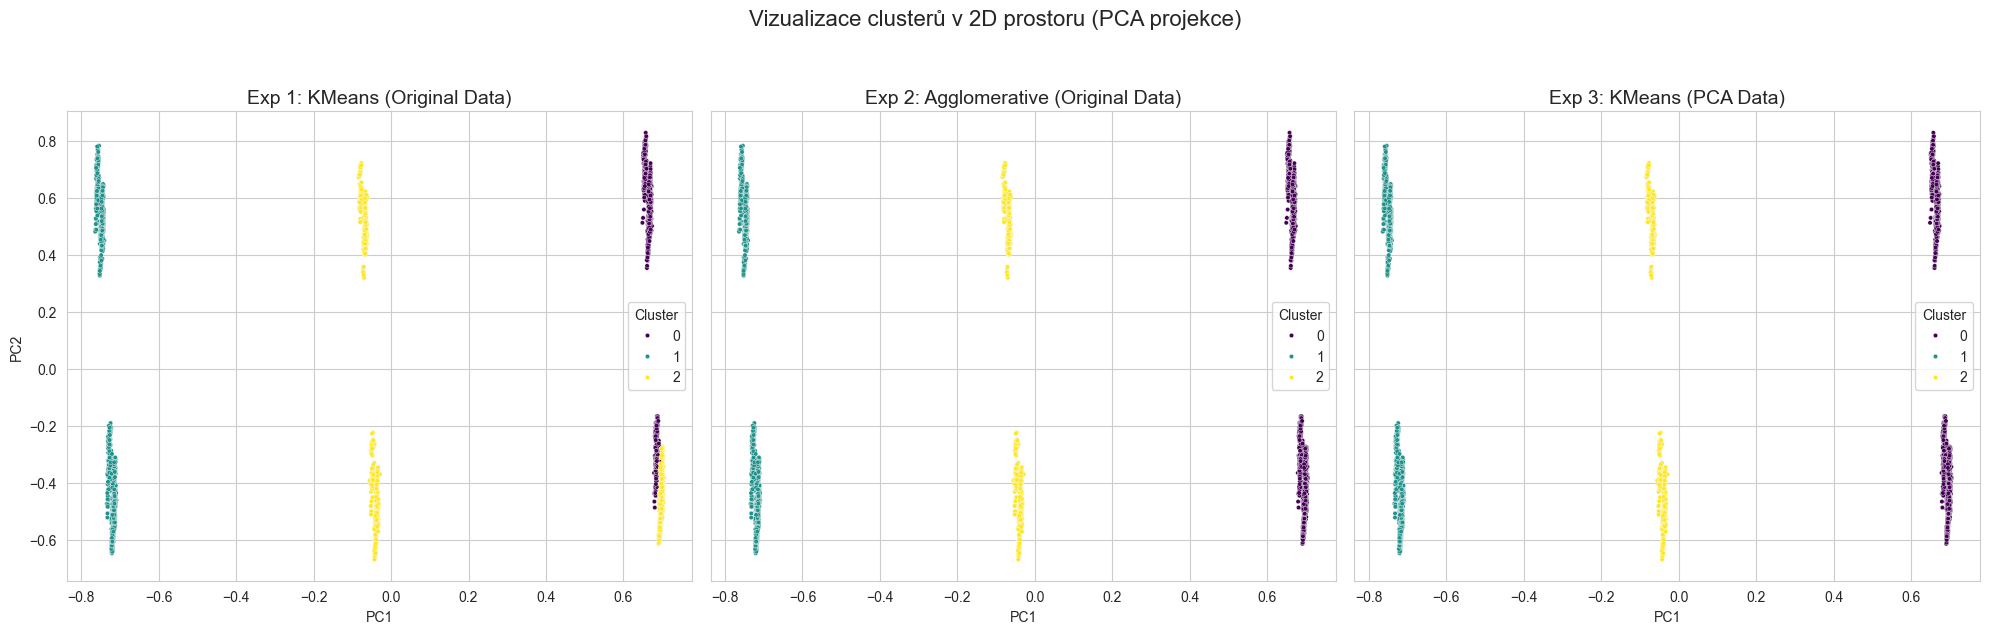

In [115]:
if X_pca.shape[1] > 2:
    X_vis = X_pca[:, :2]
else:
    X_vis = X_pca

vis_df = pd.DataFrame(X_vis, columns=['PC1', 'PC2'])
vis_df['Exp1_KMeans'] = results_df['Cluster_Exp1_KMeans'].values
vis_df['Exp2_Agglo'] = results_df['Cluster_Exp2_Agglo'].values
vis_df['Exp3_PCA_KMeans'] = results_df['Cluster_Exp3_PCA_KMeans'].values

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Experiment 1
sns.scatterplot(data=vis_df, x='PC1', y='PC2', hue='Exp1_KMeans', palette='viridis', ax=axes[0], s=10)
axes[0].set_title('Exp 1: KMeans (Original Data)', fontsize=14)
axes[0].legend(title='Cluster')

# Experiment 2
sns.scatterplot(data=vis_df, x='PC1', y='PC2', hue='Exp2_Agglo', palette='viridis', ax=axes[1], s=10)
axes[1].set_title('Exp 2: Agglomerative (Original Data)', fontsize=14)
axes[1].legend(title='Cluster')

# Experiment 3
sns.scatterplot(data=vis_df, x='PC1', y='PC2', hue='Exp3_PCA_KMeans', palette='viridis', ax=axes[2], s=10)
axes[2].set_title('Exp 3: KMeans (PCA Data)', fontsize=14)
axes[2].legend(title='Cluster')

plt.suptitle('Vizualizace clusterů v 2D prostoru (PCA projekce)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

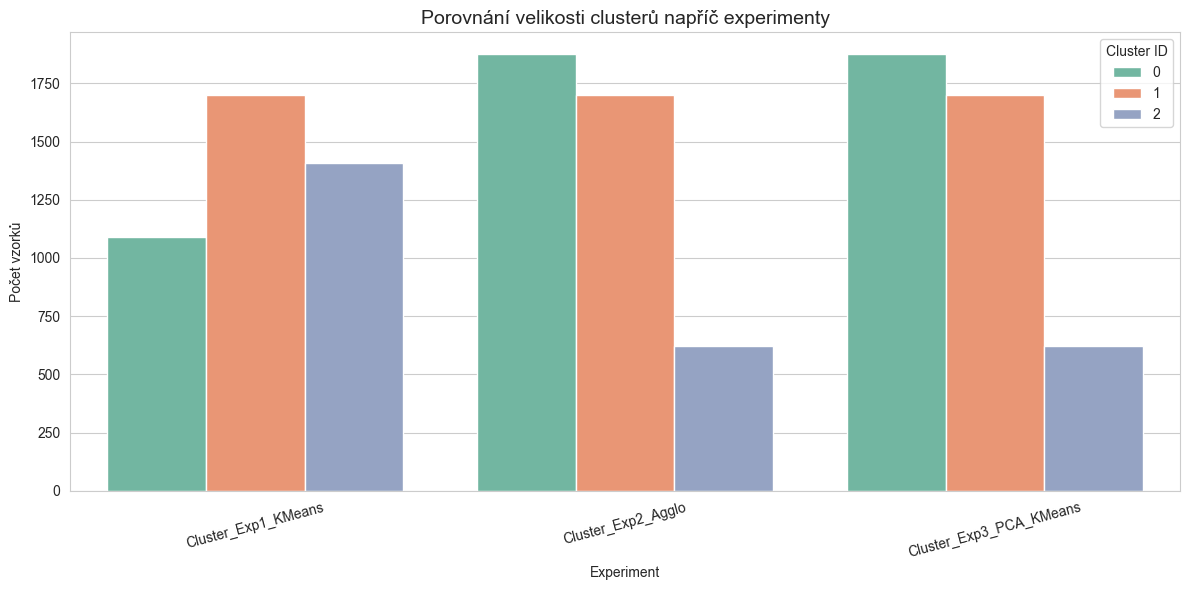

In [116]:
melted_results = results_df[['Cluster_Exp1_KMeans', 'Cluster_Exp2_Agglo', 'Cluster_Exp3_PCA_KMeans']].melt(
    var_name='Experiment', value_name='Cluster'
)

plt.figure(figsize=(12, 6))
sns.countplot(data=melted_results, x='Experiment', hue='Cluster', palette='Set2')
plt.title('Porovnání velikosti clusterů napříč experimenty', fontsize=14)
plt.xlabel('Experiment')
plt.ylabel('Počet vzorků')
plt.xticks(rotation=15)
plt.legend(title='Cluster ID')
plt.tight_layout()
plt.show()

C:\Users\ajrac\AppData\Local\Temp\ipykernel_3180\3434200526.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=score_df, x='Experiment', y='Silhouette Score', palette='Blues_d')


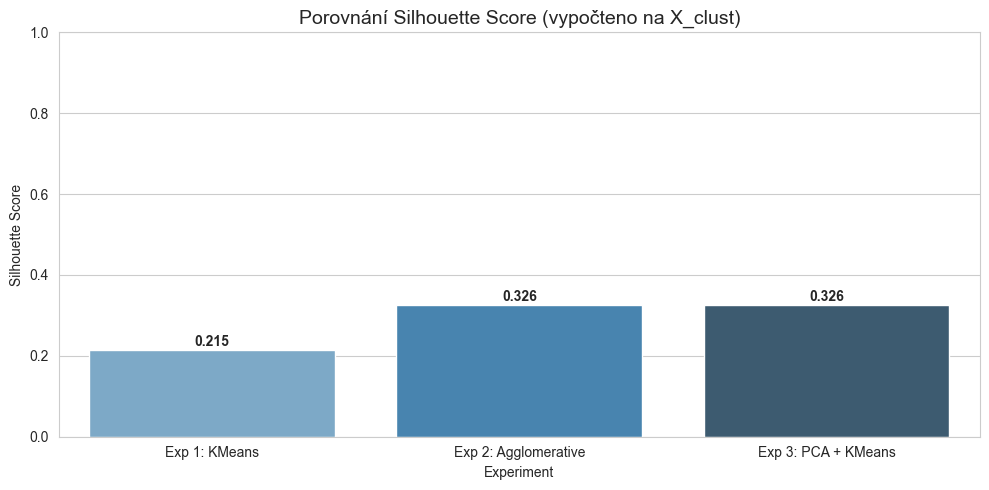

In [117]:
scores = {
    'Exp 1: KMeans': silhouette_score(X_clust, results_df['Cluster_Exp1_KMeans']),
    'Exp 2: Agglomerative': silhouette_score(X_clust, results_df['Cluster_Exp2_Agglo']),
    'Exp 3: PCA + KMeans': silhouette_score(X_clust, results_df['Cluster_Exp3_PCA_KMeans']) 
}

score_df = pd.DataFrame(list(scores.items()), columns=['Experiment', 'Silhouette Score'])

plt.figure(figsize=(10, 5))
sns.barplot(data=score_df, x='Experiment', y='Silhouette Score', palette='Blues_d')
plt.title('Porovnání Silhouette Score (vypočteno na X_clust)', fontsize=14)
plt.ylim(0, 1) # Silhouette score je max 1
for i, v in enumerate(score_df['Silhouette Score']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Vysvětlení grafů a clusterů
Grafy ukazují, že data jsou silně separována do diskrétních skupin. To naznačuje, že **binární/kategorické proměnné** (jako Gender, Smoking, Alcohol) hrají v datech dominantní roli a "přebíjí" spojité veličiny (jako BMI nebo Věk).

Níže analyzujeme:
1. **Co tvoří osy grafu (PC1 a PC2):** PC1 ukazuje směr, ve kterém se data nejvíce liší a PC2 je druhý nejdůležitější směr, kolmý na PC1.
2. **Co definuje clustery:** Podíváme se na průměrné hodnoty v každém clusteru, abychom je mohli pojmenovat (např. "Kuřáci", "Sportovci" apod.).

In [118]:
components_df = pd.DataFrame(
    pca.components_, 
    columns=X_clust.columns, 
    index=[f'PC{i+1}' for i in range(X_pca.shape[1])]
)

print("Top 5 vlivů na osu PC1")
print(components_df.loc['PC1'].abs().sort_values(ascending=False).head(5))

print("Top 5 vlivů na osu PC2")
print(components_df.loc['PC2'].abs().sort_values(ascending=False).head(5))

Top 5 vlivů na osu PC1
Gender_Female     0.715714
Gender_Male       0.697263
Family History    0.030760
Gender_Unknown    0.018451
Smoking           0.011817
Name: PC1, dtype: float64
Top 5 vlivů na osu PC2
Family History    0.969012
Smoking           0.127711
Alcohol           0.101232
Diet Score        0.076740
LengthOfStay      0.072422
Name: PC2, dtype: float64


In [119]:
cols_to_check = ['Gender_Female', 'Gender_Male', 'Gender_Unknown', 'Smoking', 'Alcohol', 'Family History', 'Age', 'BMI']

cluster_means = results_df.groupby('Cluster_Exp1_KMeans')[cols_to_check].mean()

print("--- Průměrné hodnoty v clusterech (Experiment 1) ---")
print(cluster_means.T.round(2))

--- Průměrné hodnoty v clusterech (Experiment 1) ---
Cluster_Exp1_KMeans     0     1     2
Gender_Female        1.00  0.00  0.56
Gender_Male          0.00  1.00  0.00
Gender_Unknown       0.00  0.00  0.44
Smoking              0.48  0.29  0.12
Alcohol              0.25  0.24  0.23
Family History       0.73  0.44  0.19
Age                  0.59  0.57  0.55
BMI                  0.55  0.55  0.55


In [120]:
cols_to_check = ['Gender_Female', 'Gender_Male', 'Gender_Unknown', 'Smoking', 'Alcohol', 'Family History', 'Age', 'BMI']

cluster_means = results_df.groupby('Cluster_Exp2_Agglo')[cols_to_check].mean()

print("Průměrné hodnoty v clusterech (Experiment 2)")
print(cluster_means.T.round(2))

Průměrné hodnoty v clusterech (Experiment 2)
Cluster_Exp2_Agglo     0     1     2
Gender_Female       1.00  0.00  0.00
Gender_Male         0.00  1.00  0.00
Gender_Unknown      0.00  0.00  1.00
Smoking             0.28  0.29  0.27
Alcohol             0.24  0.24  0.24
Family History      0.42  0.44  0.42
Age                 0.57  0.57  0.56
BMI                 0.55  0.55  0.56


In [121]:
cols_to_check = ['Gender_Female', 'Gender_Male', 'Gender_Unknown', 'Smoking', 'Alcohol', 'Family History', 'Age', 'BMI']

cluster_means = results_df.groupby('Cluster_Exp3_PCA_KMeans')[cols_to_check].mean()

print("Průměrné hodnoty v clusterech (Experiment 3)")
print(cluster_means.T.round(2))

Průměrné hodnoty v clusterech (Experiment 3)
Cluster_Exp3_PCA_KMeans     0     1     2
Gender_Female            1.00  0.00  0.00
Gender_Male              0.00  1.00  0.00
Gender_Unknown           0.00  0.00  1.00
Smoking                  0.28  0.29  0.27
Alcohol                  0.24  0.24  0.24
Family History           0.42  0.44  0.42
Age                      0.57  0.57  0.56
BMI                      0.55  0.55  0.56


Jediná ze zkoušených metod, která nedokázala pevně rozpoznat clustery, byla KMeans, která částešně spojila cluster 0 a 2.

Další metody byly téměř stejně, což ukazuje na fakt, že shluky v datech jsou silné. <br>
Nicméně při hlubším rozboru jde vidět, že nejdůležitějším sloupcem pro cluster je právě gender. Z medicínského hlediska to dává smysl, protože pohlaví je zásadní, nicméně pro to by stačil i filtr.

To taktéž vysvětluje, proč je cluster 3 nejmenší. Řádků kde chybí gender, bylo méně než mužů a žen.

In [122]:
gender_cols = [col for col in X_clust.columns if 'Gender' in col]
X_no_gender = X_clust.drop(columns=gender_cols)

In [123]:
X_no_gender.head()

,Age,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours
1,0.151899,0.396486,0.327152,0.506573,0.906035,0.202245,0.353968,0.425599,0.464555,0,0,0.746999,0.520463,0,0.438202,0.729487
2,0.506329,0.573438,0.545165,0.411527,0.629870,0.202245,0.572701,0.521085,0.590131,0,0,0.459834,0.409253,1,0.229963,0.357692
3,0.594937,0.703562,0.468959,0.760008,0.870130,0.499109,0.499619,0.562488,0.752321,0,0,0.289012,0.295374,0,0.223970,0.423077
4,0.708861,0.572917,0.772783,0.615416,0.805195,0.423529,0.748921,0.386577,0.645272,0,1,0.325946,0.298043,0,0.476404,0.591026
5,0.506329,0.634736,0.737739,0.483275,0.817036,0.499109,0.646543,0.613242,0.570886,1,0,0.459834,0.409253,0,0.541573,0.553846


In [124]:
pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X_no_gender)

print(f"Původní počet rysů: {X_clust.shape[1]}")
print(f"Počet rysů po PCA: {X_pca.shape[1]}")

Původní počet rysů: 19
Počet rysů po PCA: 13


In [125]:
print("Hledání optimálního počtu clusterů pro PCA + KMeans:")
for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_pca.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print(f"k = {k}: Silhouette Score = {score:.4f}")

Hledání optimálního počtu clusterů pro PCA + KMeans:
k = 2: Silhouette Score = 0.2807
k = 2: Silhouette Score = 0.2807
k = 3: Silhouette Score = 0.3012
k = 3: Silhouette Score = 0.3012
k = 4: Silhouette Score = 0.3121
k = 4: Silhouette Score = 0.3121
k = 5: Silhouette Score = 0.3615
k = 5: Silhouette Score = 0.3615
k = 6: Silhouette Score = 0.3838
k = 6: Silhouette Score = 0.3838
k = 7: Silhouette Score = 0.4125
k = 7: Silhouette Score = 0.4125
k = 8: Silhouette Score = 0.3765
k = 8: Silhouette Score = 0.3765
k = 9: Silhouette Score = 0.3372
k = 9: Silhouette Score = 0.3372
k = 10: Silhouette Score = 0.3228
k = 10: Silhouette Score = 0.3228


In [126]:
kmeans_pca = KMeans(n_clusters=7, random_state=42, n_init=10)
labels_exp3 = kmeans_pca.fit_predict(X_pca)
results_df['Cluster_Exp4_No_Gender'] = labels_exp3

In [127]:
score_no_gender = silhouette_score(X_no_gender, results_df['Cluster_Exp4_No_Gender'])
print(f"Silhouette Score (bez genderu, k=5): {score_no_gender:.4f}")

Silhouette Score (bez genderu, k=5): 0.3870


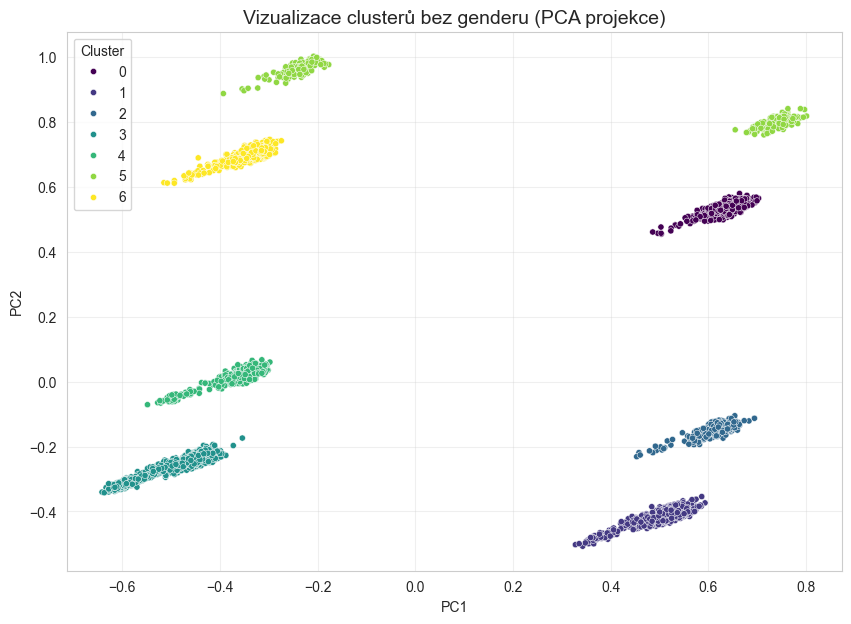

In [128]:
if X_pca.shape[1] > 2:
    X_vis_ng = X_pca[:, :2]
else:
    X_vis_ng = X_pca

vis_df_ng = pd.DataFrame(X_vis_ng, columns=['PC1', 'PC2'])
vis_df_ng['Cluster'] = results_df['Cluster_Exp4_No_Gender'].values

plt.figure(figsize=(10, 7))
sns.scatterplot(data=vis_df_ng, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=20)
plt.title('Vizualizace clusterů bez genderu (PCA projekce)', fontsize=14)
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

Rozdělení clusterů ukazuje na fakt, že KMeans není nejlepší volbou, protože se snaží shlukovat data do kruhů, zatímco data jsou spíše řetězcová.

In [129]:
cols_to_check_ng = ['Smoking', 'Alcohol', 'Family History', 'Age', 'BMI', 'Blood Pressure', 'Cholesterol']
cluster_means_ng = results_df.groupby('Cluster_Exp4_No_Gender')[cols_to_check_ng].mean()

print("Průměrné hodnoty v clusterech (Experiment 4 - Bez Genderu)")
print(cluster_means_ng.T.round(2))

Průměrné hodnoty v clusterech (Experiment 4 - Bez Genderu)
Cluster_Exp4_No_Gender     0     1     2     3     4     5     6
Smoking                 1.00  0.00  0.00  0.00  0.00  1.00  1.00
Alcohol                 0.00  0.00  1.00  0.00  1.00  1.00  0.00
Family History          1.00  1.00  1.00  0.00  0.00  0.43  0.00
Age                     0.59  0.58  0.60  0.54  0.56  0.61  0.56
BMI                     0.55  0.56  0.56  0.54  0.55  0.57  0.54
Blood Pressure          0.57  0.54  0.55  0.51  0.54  0.56  0.54
Cholesterol             0.58  0.56  0.58  0.54  0.58  0.59  0.56


In [130]:
agglo = AgglomerativeClustering(n_clusters=7)
labels_exp2 = agglo.fit_predict(X_clust)
results_df['Cluster_Exp4_Agglo_No_Gender'] = labels_exp2

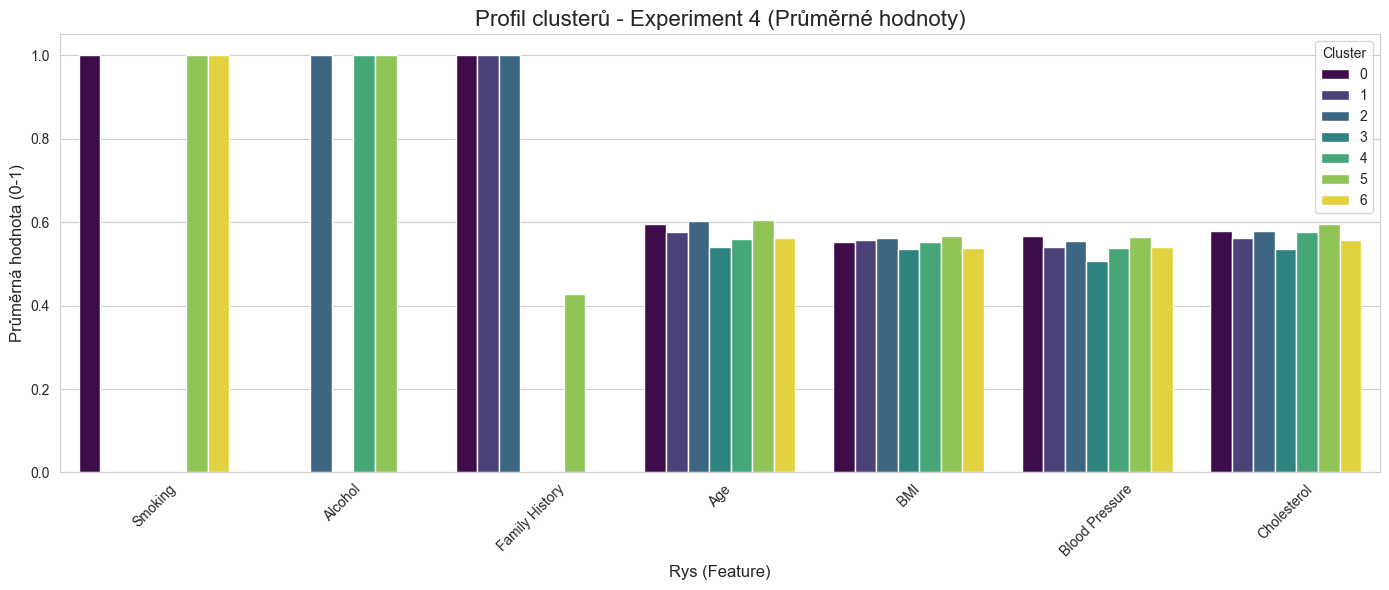

In [131]:
melted_means = cluster_means_ng.reset_index().melt(id_vars='Cluster_Exp4_No_Gender', var_name='Feature', value_name='Mean Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=melted_means, x='Feature', y='Mean Value', hue='Cluster_Exp4_No_Gender', palette='viridis')
plt.title('Profil clusterů - Experiment 4 (Průměrné hodnoty)', fontsize=16)
plt.xlabel('Rys (Feature)', fontsize=12)
plt.ylabel('Průměrná hodnota (0-1)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

Po odstranění pohlaví je mnohem více clusterů a již nelze jednoduše určit, podle čeho se clustery dělí.

# 5. Experiment - DBSCAN (na datech bez genderu)
Zkusíme použít hustotní shlukování (DBSCAN). Tato metoda umí detekovat shluky libovolného tvaru a také odlehlé hodnoty (šum).
Pro DBSCAN je klíčové nastavit parametry `eps` (dosah) a `min_samples` (minimální počet bodů pro tvoření jádra clusteru).

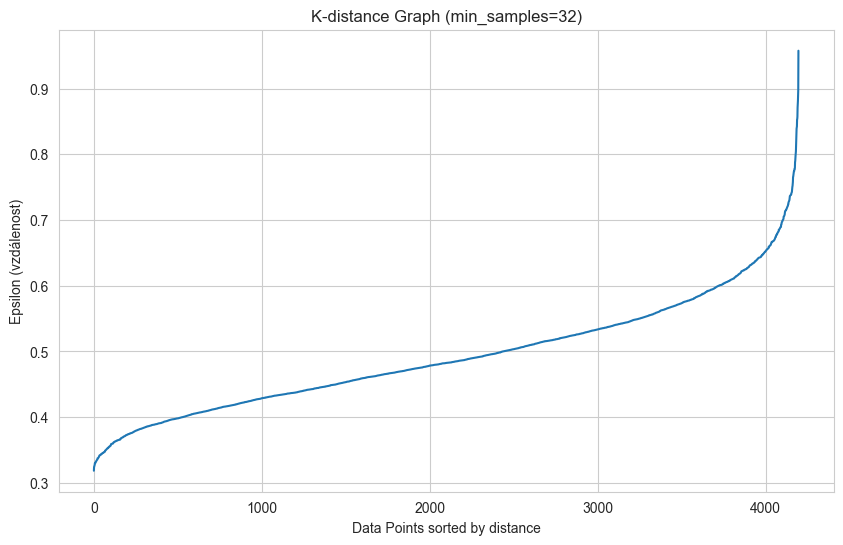

In [132]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

min_samples = 2 * X_no_gender.shape[1] 

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_no_gender)
distances, indices = neighbors_fit.kneighbors(X_no_gender)

distances = np.sort(distances[:, min_samples-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'K-distance Graph (min_samples={min_samples})')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon (vzdálenost)')
plt.grid(True)
plt.show()

Počet nalezených clusterů: 8
Počet šumových bodů (noise): 4


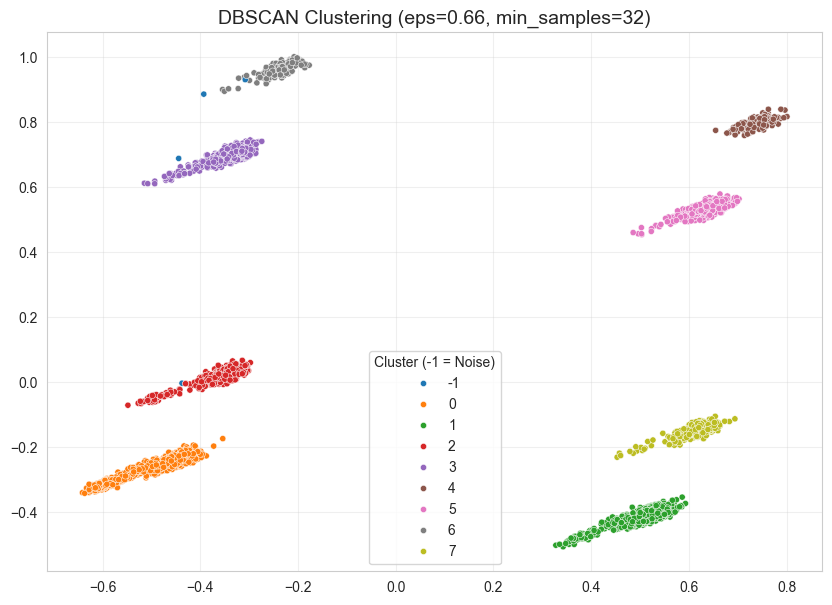

In [133]:
eps_value = 0.66 

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(X_no_gender)

results_df['Cluster_Exp5_DBSCAN'] = labels_dbscan

n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_ = list(labels_dbscan).count(-1)

print(f'Počet nalezených clusterů: {n_clusters_}')
print(f'Počet šumových bodů (noise): {n_noise_}')

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_vis_ng[:, 0], y=X_vis_ng[:, 1], hue=labels_dbscan, palette='tab10', s=20)
plt.title(f'DBSCAN Clustering (eps={eps_value}, min_samples={min_samples})', fontsize=14)
plt.legend(title='Cluster (-1 = Noise)')
plt.grid(True, alpha=0.3)
plt.show()

DBSAN, který je pro řetězcová data lepší, našel 8 clusterů.

In [134]:
cols_to_check_ng = ['Smoking', 'Alcohol', 'Family History', 'Age', 'BMI', 'Blood Pressure', 'Cholesterol']
cluster_means_ng = results_df.groupby('Cluster_Exp5_DBSCAN')[cols_to_check_ng].mean()

print("Průměrné hodnoty v clusterech (Experiment 5 - Bez Genderu)")
print(cluster_means_ng.T.round(2))

Průměrné hodnoty v clusterech (Experiment 5 - Bez Genderu)
Cluster_Exp5_DBSCAN    -1     0     1     2     3     4     5     6     7
Smoking              0.75  0.00  0.00  0.00  1.00  1.00  1.00  1.00  0.00
Alcohol              0.75  0.00  0.00  1.00  0.00  1.00  0.00  1.00  1.00
Family History       0.00  0.00  1.00  0.00  0.00  1.00  1.00  0.00  1.00
Age                  0.29  0.54  0.58  0.56  0.56  0.63  0.59  0.60  0.60
BMI                  0.44  0.54  0.56  0.55  0.54  0.56  0.55  0.57  0.56
Blood Pressure       0.38  0.51  0.54  0.54  0.54  0.57  0.57  0.56  0.55
Cholesterol          0.49  0.54  0.56  0.58  0.56  0.60  0.58  0.59  0.58


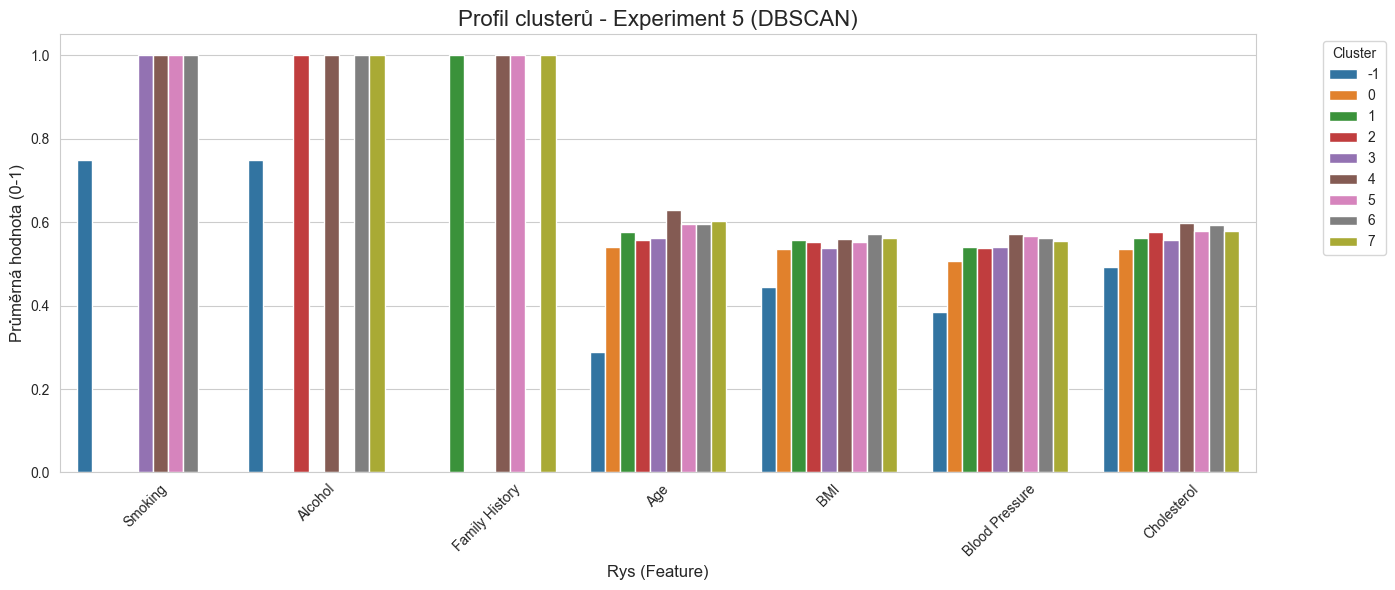

In [135]:
melted_means_dbscan = cluster_means_ng.reset_index().melt(id_vars='Cluster_Exp5_DBSCAN', var_name='Feature', value_name='Mean Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=melted_means_dbscan, x='Feature', y='Mean Value', hue='Cluster_Exp5_DBSCAN', palette='tab10')
plt.title('Profil clusterů - Experiment 5 (DBSCAN)', fontsize=16)
plt.xlabel('Rys (Feature)', fontsize=12)
plt.ylabel('Průměrná hodnota (0-1)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

Důležitým rysem pro DBSCAN byly bitové hodnoty, které vytvářejí přirozené ostrovy, protože jsou striktně děleny na 0 a 1, což je větší rozdíl než u spojitých hodnot. <br>
DBSCAN tyto ostrovy najde a označí jako clustery, spojité hodnoty pak mají menší roli při separaci skupin.

Z počtu clusterů jde také poznat, že to je 2^3, což je počet všech kombinací binárních hodnot.

In [136]:
score_no_gender = silhouette_score(X_no_gender, results_df['Cluster_Exp5_DBSCAN'])
print(f"Silhouette Score (bez genderu, k=8): {score_no_gender:.4f}")

Silhouette Score (bez genderu, k=8): 0.3994


Sillhouette score je o 0,0734 lepší než u datasetu s genderem a o 0,0124 lepší než u PCA s KMeans bez genderu, takže DBSCAN se ukázalo jako správná volba.